In [ ]:
%matplotlib inline
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from IPython import display

In [7]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/gan_loss_epoch_%d.png' % epoch)
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if not os.path.exists('./images/'):
        os.mkdir('./images')
    plt.savefig('./images/gan_generated_image_epoch_%d.png' % epoch)
    plt.show()
    
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)
    for e in tqdm(range(int(epochs))):
        for i in range(int(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[i*batchSize:(i+1)*batchSize]
            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])
            # Labels for generated and real data
            yDis = np.zeros([2*batchSize,2])
            # One-sided label smoothing
            yDis[batchSize::,0] = 1
            yDis[0:batchSize, 1] = 1
            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.zeros([batchSize,2])
            yGen[:, 1] = 1
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        if e == 0 or e % 5 == 4:
            plotGeneratedImages(e)
    # Plot losses from every epoch
    plotLoss(e)

In [8]:
randomDim = 100

# Optimizer
opt = Adam(lr=1e-4, beta_1=0.5)
dopt = Adam(lr=1e-3, beta_1=0.5)

In [9]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype(np.float32)/255
X_train = X_train.reshape(60000, 784)

In [10]:
# Build model

# Build generator
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer='glorot_uniform'))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512, kernel_initializer='RandomNormal'))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024, kernel_initializer='RandomNormal'))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='sigmoid', kernel_initializer='RandomNormal'))
generator.compile(loss='binary_crossentropy', optimizer=opt)

# Build discriminator
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer='glorot_uniform'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512, kernel_initializer='RandomNormal'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256, kernel_initializer='RandomNormal'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(2, activation='softmax', kernel_initializer='RandomNormal'))
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)

# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='categorical_crossentropy', optimizer=opt)

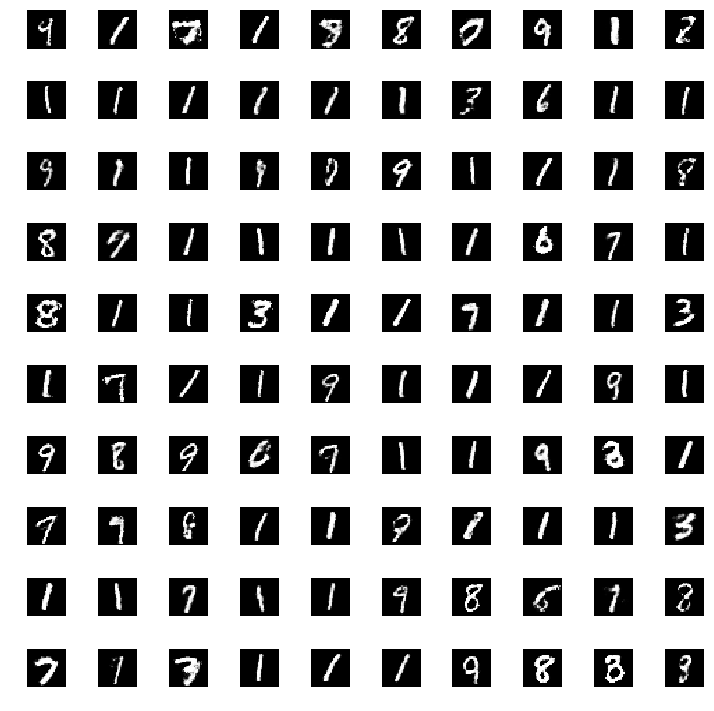

100%|██████████| 100/100 [16:56<00:00, 11.67s/it]


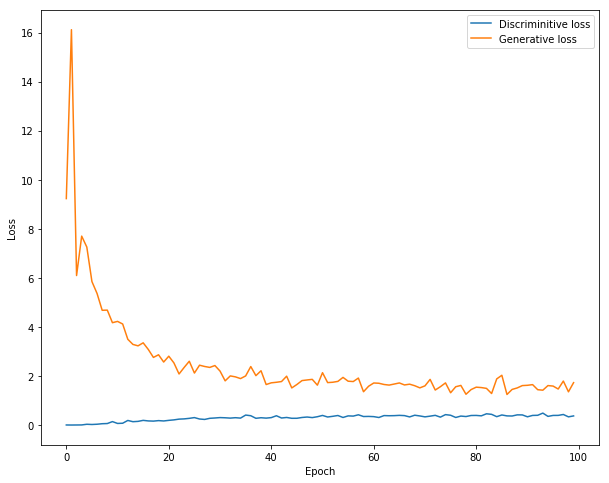

In [11]:
dLosses = []
gLosses = []

train(100,128)